In [62]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import butter, lfilter, freqz
from scipy.interpolate import interp1d


In [63]:
def curve_rayleigh(t,scale1=0.4,scale2 = .25,val=30,offset=10):
    return 30*(t / scale1**2) * np.exp(-t**2 / (2 * scale2**2))+offset

### First generate a simulated bearing failure signal following: 

#### $y(k)=\sum_{r}A_r\sin\left(2\pi f\left[\dfrac{k}{F}-\dfrac{r}{f_m}\right]\right)\cdot e^{-\beta\left(\dfrac{k}{F}-\dfrac{r}{f_m}\right)}\cdot u\left(\dfrac{k}{F}-\dfrac{r}{f_m}\right)$

##### details behind the reasoning: https://dsp.stackexchange.com/questions/41851/impulse-signal-function/88534#88534

##### The red dots in the figure show the moments when impacts due to the failure occurred (one per revolution), starting from the first failure at $t = 0$

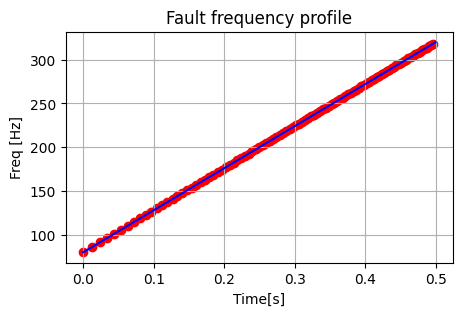

In [64]:
Ar= 1   #Amplitude
f = 2000    #Resonant Frequency in Hz
b=500       #Exponential decay factor
α=4      #Fault characteristic coeficient
fs=1e4  #Freq. Sampling

N=5000
n=np.arange(N)
t=n/fs

#fr_var=curve_rayleigh(t)
fr_var=np.linspace(20,80,N)
#fr_var=25*np.ones((N,))
f_fail=α*fr_var
ω_fail=2*np.pi*f_fail
θr_fail=np.cumsum(ω_fail)/fs

t_indexes=[]
t_impact=[]
N_of_impacts=np.int32(np.floor(np.max(θr_fail)/(2*np.pi)))+1
for i in range(N_of_impacts):
    t_index=np.argmin(np.abs(θr_fail-i*2*np.pi))
    t_indexes.append(t_index)
    t_impact.append(t[t_index])
    #print(i,t_index,t[t_index])

impacts=(np.array(t_indexes),np.array(t_impact))

%matplotlib inline
plt.figure(figsize=(5,3)) ### change tuple for better visualization or change inline for qt in %matplotlib inline 
plt.plot(t,f_fail,color='blue')
plt.title('Fault frequency profile')
plt.xlabel('Time[s]')
plt.ylabel('Freq [Hz]')
plt.grid()
plt.scatter(impacts[1],f_fail[impacts[0]],color='red',marker='o')
plt.show()

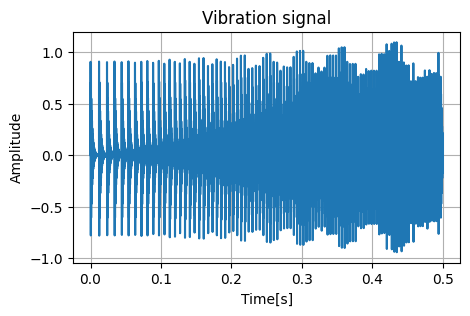

In [65]:
Sx_var=np.zeros((N,))

for r in range(len(t_impact)):
    Sx_var+=Ar*np.sin(2*np.pi*f*(n/fs-t_impact[r]))*np.exp(-b*(n/fs-t_impact[r]))*np.heaviside(n/fs-t_impact[r], 1)

%matplotlib inline
plt.figure(figsize=(5,3))
plt.plot(t,Sx_var)
plt.grid(True)
plt.title('Vibration signal')
plt.xlabel('Time[s]')
plt.ylabel('Amplitude')
#plt.savefig('Sx.pdf',bbox_inches='tight')
plt.show()

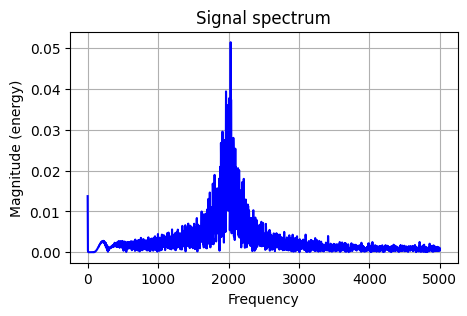

In [66]:
%matplotlib inline 
plt.figure(figsize=(5,3))
spectrum=plt.magnitude_spectrum(Sx_var, Fs=fs, color='blue')
plt.title("Signal spectrum")
plt.grid(True)
plt.show()

___
#### Interpolation example

##### https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html

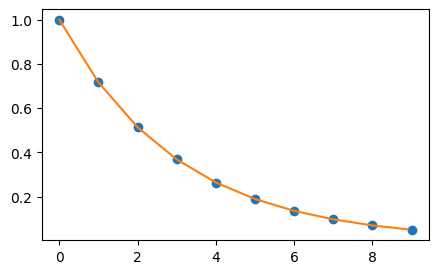

In [67]:
from scipy import interpolate

x = np.arange(0, 10)
y = np.exp(-x/3.0)
f = interpolate.interp1d(x, y)

xnew = np.arange(0, 9, 0.1)
ynew = f(xnew)   # use interpolation function returned by `interp1d`
plt.figure(figsize=(5,3))
plt.plot(x, y, 'o', xnew, ynew, '-')
plt.show()

___

In [68]:
def angular_sampling(Sx,fr):
    tref1 = np.cumsum(fr)
    tref1 = np.insert(tref1[:-1], 0, 0)
    tref2 = np.linspace(0, 2 * len(tref1), num= len(tref1)) * np.mean(fr_var)
    idx = np.argmin(np.abs(tref2 - tref1[-1]))
    tref2_ = tref2[:idx+1]
    interpolator = interp1d(tref1, Sx, kind='cubic',fill_value="extrapolate")
    Sx_ang = interpolator(tref2_)
    return Sx_ang

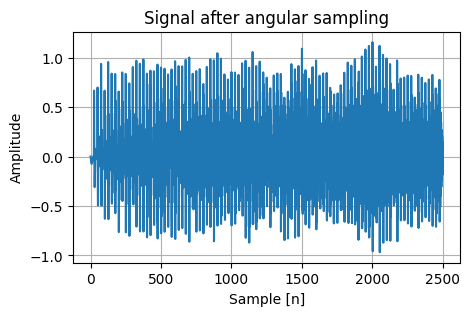

In [69]:
Sx_ang=angular_sampling(Sx_var,fr_var)
plt.figure(figsize=(5,3))
plt.plot(Sx_ang)
plt.grid(True)
plt.title('Signal after angular sampling')
plt.xlabel('Sample [n]')
plt.ylabel('Amplitude')
#plt.savefig('Sx.pdf',bbox_inches='tight')
plt.show()

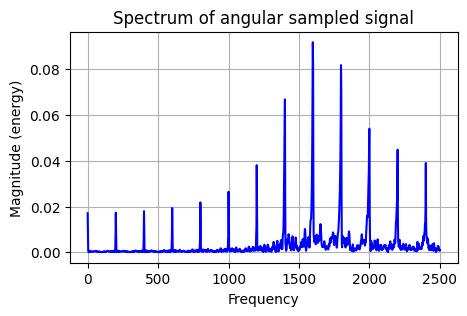

In [70]:
%matplotlib inline 
plt.figure(figsize=(5,3))
M=len(Sx_var)/len(Sx_ang)
spectrum=plt.magnitude_spectrum(Sx_ang, Fs=fs/M, color='blue')
plt.title('Spectrum of angular sampled signal')
plt.grid(True)
plt.show()

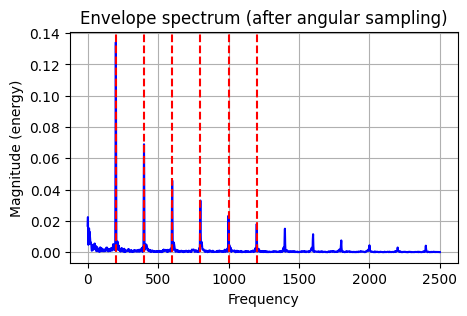

In [71]:
Sx_ang_env=np.abs(signal.hilbert(Sx_ang))

#%matplotlib qt 
%matplotlib inline

N_red_lines=6

plt.figure(figsize=(5,3))
#spectrum=plt.magnitude_spectrum(Sx_ang_env, Fs=fs/M, color='blue')
spectrum=plt.magnitude_spectrum(Sx_ang_env-np.mean(Sx_ang_env), Fs=fs/M, color='blue')
plt.title('Envelope spectrum (after angular sampling)')

for i in range(N_red_lines):
    plt.axvline(x = np.mean((i+1)*f_fail),color='r',linestyle='dashed')
plt.grid(True)
#plt.savefig('env_spect.pdf',bbox_inches='tight')
plt.show()

___
#### Idea paper Borghesani 2013

##### Title: A new procedure for using envelope analysis for rolling element bearing diagnostics in variable operating conditions

##### https://www.sciencedirect.com/science/article/pii/S088832701200372X

* First: Band pass & squaring
* Second: Angular sampling

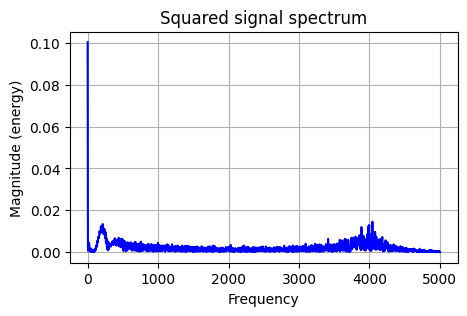

In [72]:
Sx_var_2=Sx_var**2

%matplotlib inline 
plt.figure(figsize=(5,3))
spectrum=plt.magnitude_spectrum(Sx_var_2, Fs=fs, color='blue')
plt.title('Squared signal spectrum')
plt.grid(True)
plt.show()

___
#### Low pass filter (test): 

##### https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units

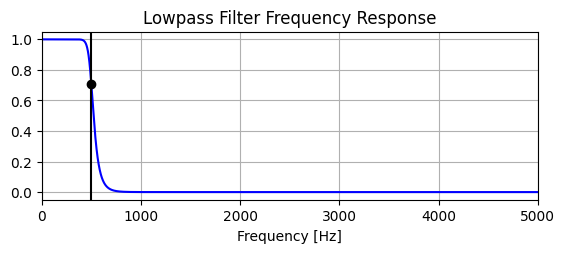

In [73]:
def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

cutoff=500
order=12

b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, fs=fs, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(w, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

___

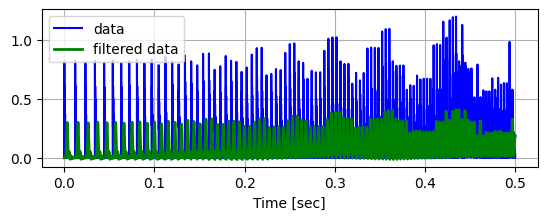

In [74]:
Sx_fil = butter_lowpass_filter(Sx_var_2, cutoff, fs, order)

plt.subplot(2, 1, 2)
plt.plot(t, Sx_var_2, 'b-', label='data')
plt.plot(t, Sx_fil, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

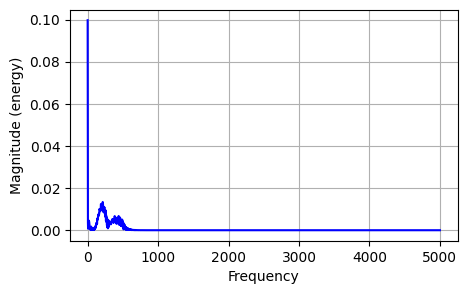

In [75]:
%matplotlib inline
plt.figure(figsize=(5,3))
spectrum=plt.magnitude_spectrum(Sx_fil, Fs=fs, color='blue')
plt.grid(True)
plt.show()

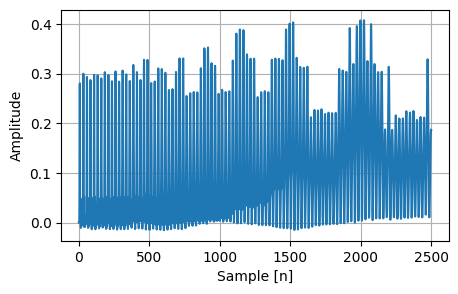

In [76]:
Sx_fil_ang=angular_sampling(Sx_fil,fr_var)
#Sx_fil_ang=angular_sampling(Sx_var_2,fr_var)
plt.figure(figsize=(5,3))
plt.plot(Sx_fil_ang)
plt.grid(True)
plt.xlabel('Sample [n]')
plt.ylabel('Amplitude')
#plt.savefig('Sx.pdf',bbox_inches='tight')
plt.show()

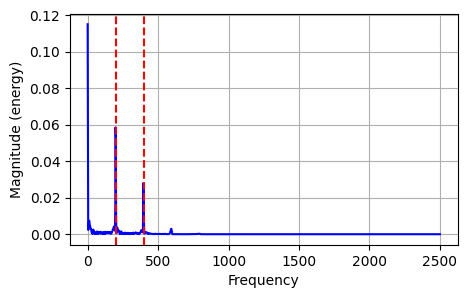

In [77]:
%matplotlib inline 
plt.figure(figsize=(5,3))
M=len(Sx_fil)/len(Sx_fil_ang)
spectrum=plt.magnitude_spectrum(Sx_fil_ang, Fs=fs/M, color='blue')

N_red_lines=2
for i in range(N_red_lines):
    plt.axvline(x = np.mean((i+1)*f_fail),color='r',linestyle='dashed')

plt.grid(True)
plt.show()

#### Without the lowpass filter

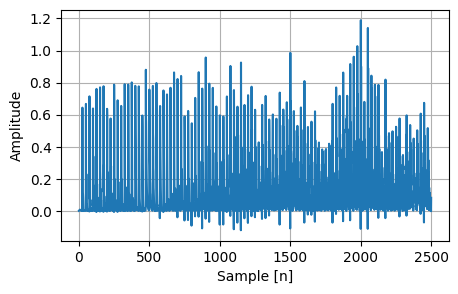

In [78]:
Sx_ang=angular_sampling(Sx_var_2,fr_var)
plt.figure(figsize=(5,3))
plt.plot(Sx_ang)
plt.grid(True)
plt.xlabel('Sample [n]')
plt.ylabel('Amplitude')
#plt.savefig('Sx.pdf',bbox_inches='tight')
plt.show()

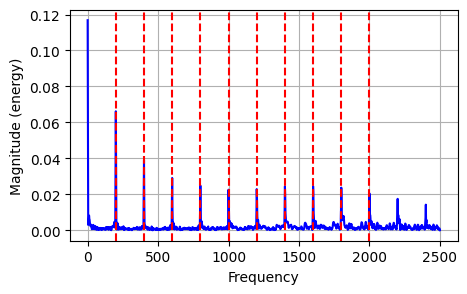

In [79]:
plt.figure(figsize=(5,3))
M=len(Sx_var_2)/len(Sx_ang)
spectrum=plt.magnitude_spectrum(Sx_ang, Fs=fs/M, color='blue')

N_red_lines=10
for i in range(N_red_lines):
    plt.axvline(x = np.mean((i+1)*f_fail),color='r',linestyle='dashed')

plt.grid(True)
plt.show()

### Other idea:

##### Substitute squaring with the abs of the analytic signal

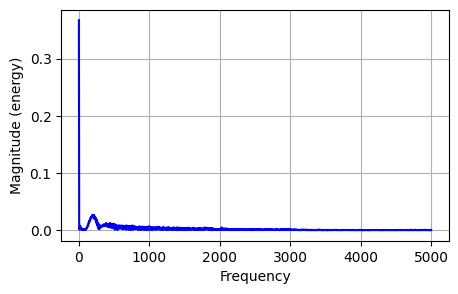

In [80]:
Sx_var_env=np.abs(signal.hilbert(Sx_var))
#plt.plot(Sx_var)
#plt.plot(Sx_var_env)
%matplotlib inline
plt.figure(figsize=(5,3))
spectrum=plt.magnitude_spectrum(Sx_var_env, Fs=fs, color='blue')
plt.grid(True)
plt.show()

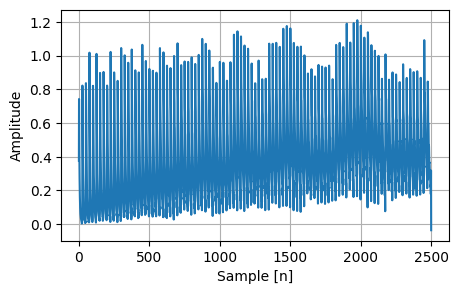

In [81]:
Sx_var_env_ang_2=angular_sampling(Sx_var_env,fr_var)
plt.figure(figsize=(5,3))
plt.plot(Sx_var_env_ang_2)
#plt.plot(Sx_ang)
plt.grid(True)
plt.xlabel('Sample [n]')
plt.ylabel('Amplitude')
#plt.savefig('Sx.pdf',bbox_inches='tight')
plt.show()

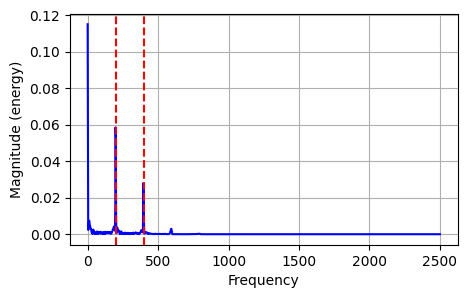

In [82]:
%matplotlib inline 
plt.figure(figsize=(5,3))
M=len(Sx_var_env)/len(Sx_var_env_ang_2)
spectrum=plt.magnitude_spectrum(Sx_fil_ang, Fs=fs/M, color='blue')

N_red_lines=2
for i in range(N_red_lines):
    plt.axvline(x = np.mean((i+1)*f_fail),color='r',linestyle='dashed')

plt.grid(True)
plt.show()

___
#### Upsampling test

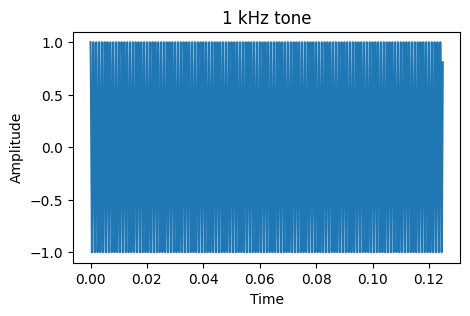

In [96]:
t_=t[:int(len(t)/4)]
Sx_test=1*np.cos(2*np.pi*1000*t_)

plt.figure(figsize=(5,3))
plt.title('1 kHz tone')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.plot(t_,Sx_test)
plt.show()

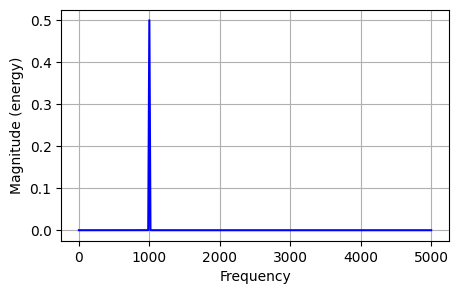

In [97]:
plt.figure(figsize=(5,3))
spectrum=plt.magnitude_spectrum(Sx_test, Fs=fs, color='blue')
plt.grid(True)
plt.show()

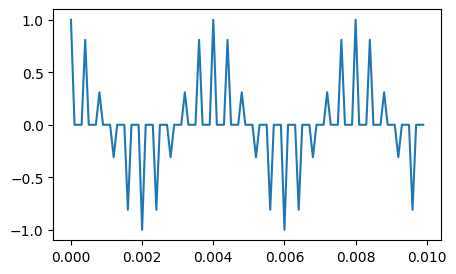

In [101]:
Sx_pad0=np.zeros(Sx_var.shape)
for i in range(len(Sx_test)):
    Sx_pad0[4*i]=Sx_test[i]
plt.figure(figsize=(5,3))
plt.plot(t[:100],Sx_pad0[:100])
plt.show()

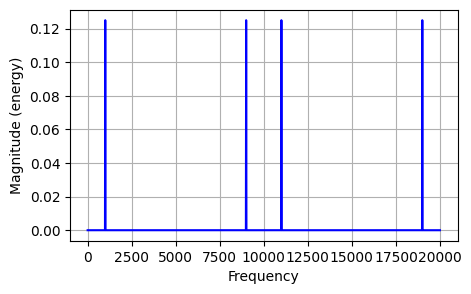

Frequency peak: 1000.0 Hz


In [112]:
#%matplotlib qt
%matplotlib inline 
plt.figure(figsize=(5,3))
L=len(Sx_var)/len(Sx_test)
spectrum=plt.magnitude_spectrum(Sx_pad0, Fs=L*fs, color='blue')
plt.grid(True)
plt.show()
print('Frequency peak:', spectrum[1][np.argmax(spectrum[0])], 'Hz')